<a href="https://colab.research.google.com/github/NotBizzaark/PyTorch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Convert MNIST Image files into a 4-D Tensor (# of images, height, width, color)
transform = transforms.ToTensor()

In [6]:
# Train data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.38MB/s]


In [7]:
# Test data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
# Create samll batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [11]:
# Define CNN model
# Describe convolutional layer and what it does
conv1 = nn.Conv2d(1, 6, 3, 1) # input, output, kernal, stride
conv2 = nn.Conv2d(6, 16, 3, 1) # input, output, kernal, stride

In [12]:
# Grab one MNIST record
for i, (X_train, y_train) in enumerate(train_data):
  break

In [13]:
X_train.shape

torch.Size([1, 28, 28])

In [14]:
x = X_train.view(1, 1, 28, 28)

In [15]:
# 1st convolution
x = F.relu(conv1(x)) # Rectified Linear unit for our activation function

In [16]:
x.shape
# 1 -> Image, 6 ->

torch.Size([1, 6, 26, 26])

In [17]:
# pass through cooling layer
x = F.max_pool2d(x, 2,2) # kernel of 2 & stride 0f 2

In [19]:
x.shape # we made 2 pools so 26 is divided into 2 parts/pools hence 13

torch.Size([1, 6, 13, 13])

In [20]:
# 2nd convolution layer
x = F.relu(conv2(x))

In [21]:
x.shape # we didn't set padding so we lose 2 pixels around the outside

torch.Size([1, 16, 11, 11])

In [22]:
x = F.max_pool2d(x, 2,2)

In [23]:
x.shape # 11/2 = 5.5 so we round down because we can't invert data to round up

torch.Size([1, 16, 5, 5])

In [24]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)

    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2,2)

    # Re-view to flatten the data
    x = x.view(-1, 16*5*5) # negative one so we can vary the batch size

    #Connected Layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [25]:
# Create instance of model
torch.manual_seed(32)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [26]:
# Loss Function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller th lr, longer its gonna take to train

In [28]:
import time
start_time = time.time()

# Create variables to track
epochs = 7
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of epochs
for i in range(epochs):
  train_corr = 0
  test_corr = 0

  # Train
  for j, (X_train, y_train) in enumerate(train_loader):
    j+=1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1] # add up the numbers of correct predictions
    batch_corr = (predicted == y_train).sum()
    train_corr += batch_corr

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if j % 600 == 0:
      print(f'Epoch: {i}  Step: {j}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(train_corr)

  # Test
  with torch.no_grad():# no gradient so we don't update our weights and biases with test
    for k, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      test_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)


current_time = time.time()
total = current_time - start_time
print(f'Total training time: {total/60} minutes. ')

Epoch: 0  Step: 600  Loss: 0.1354280412197113
Epoch: 0  Step: 1200  Loss: 0.21892504394054413
Epoch: 0  Step: 1800  Loss: 0.28586137294769287
Epoch: 0  Step: 2400  Loss: 0.029126722365617752
Epoch: 0  Step: 3000  Loss: 0.02311210334300995
Epoch: 0  Step: 3600  Loss: 0.02370912954211235
Epoch: 0  Step: 4200  Loss: 0.012558030895888805
Epoch: 0  Step: 4800  Loss: 0.11266636848449707
Epoch: 0  Step: 5400  Loss: 0.2566693127155304
Epoch: 0  Step: 6000  Loss: 0.001253939582966268
Epoch: 1  Step: 600  Loss: 0.4028131067752838
Epoch: 1  Step: 1200  Loss: 0.0017857138300314546
Epoch: 1  Step: 1800  Loss: 0.047355059534311295
Epoch: 1  Step: 2400  Loss: 0.002876503858715296
Epoch: 1  Step: 3000  Loss: 0.003816679585725069
Epoch: 1  Step: 3600  Loss: 0.006251235958188772
Epoch: 1  Step: 4200  Loss: 0.02115803398191929
Epoch: 1  Step: 4800  Loss: 0.03699566423892975
Epoch: 1  Step: 5400  Loss: 0.0004735838738270104
Epoch: 1  Step: 6000  Loss: 0.26955169439315796
Epoch: 2  Step: 600  Loss: 0.00676

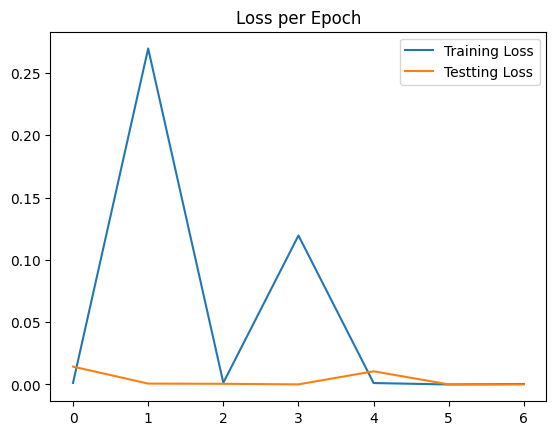

In [30]:
# Graph the loss of each epoch
train_losses = [tl.item() for tl in train_losses]
# test_losses = [tl.item() for tl in test_losses]

plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Testting Loss')
plt.title('Loss per Epoch')
plt.legend()

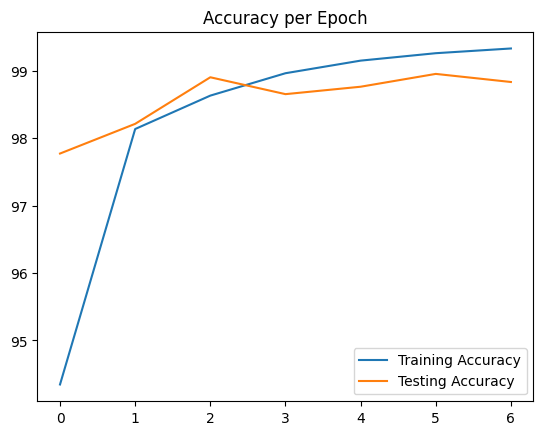

In [33]:
# Graph the accuracy for each epoch
plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/100 for t in test_correct], label = "Testing Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

In [34]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [35]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()



In [39]:
correct.item()/len(test_data)*100

98.83

In [40]:
# Grad an Image
test_data[3131] # tensor with an image

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [41]:
test_data[3131][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [42]:
test_data[3131][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

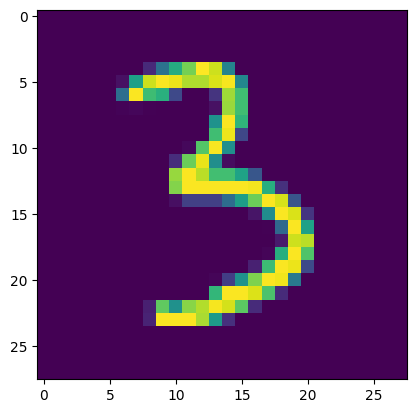

In [43]:
plt.imshow(test_data[3131][0].reshape(28, 28))

In [44]:
# Pass the image through model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[3131][0].reshape(1, 1, 28, 28))

In [46]:
new_prediction

tensor([-37.6754, -25.5826, -27.8601,   0.0000, -39.0897, -19.1769, -37.9605,
        -32.4388, -30.8201, -32.1095])

In [47]:
new_prediction.argmax()

tensor(3)

In [51]:
test_data[2000][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1922,
         0.6235, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0471, 0.4863, 0.4431,
         0.3020, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

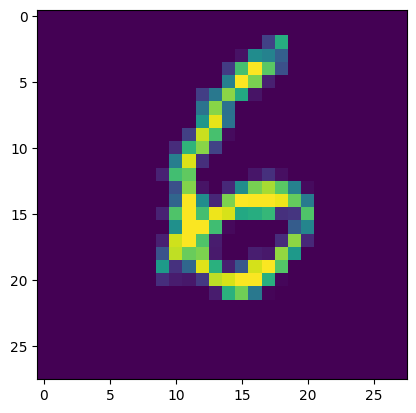

In [55]:
plt.imshow(test_data[2000][0].reshape(28, 28))

In [56]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[2000][0].reshape(1, 1, 28, 28))

In [57]:
new_prediction

tensor([[-1.5484e+01, -3.2307e+01, -2.1325e+01, -2.3048e+01, -1.9251e+01,
         -1.3474e+01, -1.6689e-06, -4.0802e+01, -1.8346e+01, -2.7328e+01]])

In [58]:
new_prediction.argmax()

tensor(6)